<a href="https://colab.research.google.com/github/brittbowers/heartsounds_classification/blob/master/phonocardiogram_img_fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Using Fast.ai Library to Classify Normal and Abnormal Heartsounds

Note: See preprocessing notebook for data collection, filtering, and transformation

## Imports

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate
from google.colab import drive
import re

In [0]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


## Get file path and data structure

In [0]:
ls

gdrive/  sample_data/


In [0]:
cd 'gdrive/My Drive/heartsound_challenge'

/content/gdrive/My Drive/heartsound_challenge


In [0]:
path_train = 'train/'
fnames = get_image_files(path_train)

In [0]:
path_test = 'test/'
fnames_test = get_image_files(path_test)

In [0]:
fnames[:5]

[PosixPath('train/9002_-1.png'),
 PosixPath('train/9003_-1.png'),
 PosixPath('train/9004_-1.png'),
 PosixPath('train/9005_-1.png'),
 PosixPath('train/9006_-1.png')]

In [0]:
bs = 64

In [0]:
pat = r'(?<=\_)(.*?)(?=\.)'

In [0]:
data = ImageDataBunch.from_name_re(path_train, fnames, pat, size=224, bs=bs
                                  ).normalize(imagenet_stats)

In [0]:
data_test = ImageDataBunch.from_name_re(path_test, fnames_test, pat,size=224, bs=bs).normalize(imagenet_stats)

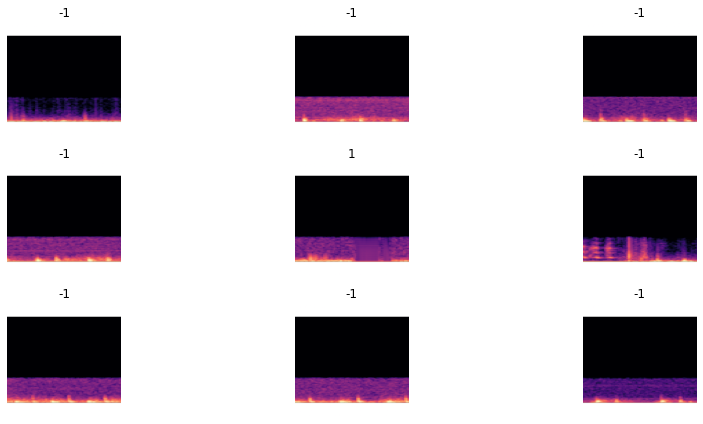

In [0]:
data.show_batch(rows=3, figsize=(14,6))

In [0]:
# What classes are we predicting? (-1: normal, 1: abnormal)
print(data.classes)

['-1', '1']


In [0]:
len(data.classes), data.c

(2, 2)

## Training: Resnet 34

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [0]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [0]:
# Epochs = 4
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.565894,0.249128,0.097500,01:58
1,0.267200,0.166997,0.069000,01:58
2,0.195288,0.148971,0.065500,01:59
3,0.141035,0.143029,0.055500,01:59


In [0]:
learn.save('stage-1')

## Results

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

In [0]:
ls

shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
ls: cannot open directory '.': Transport endpoint is not connected


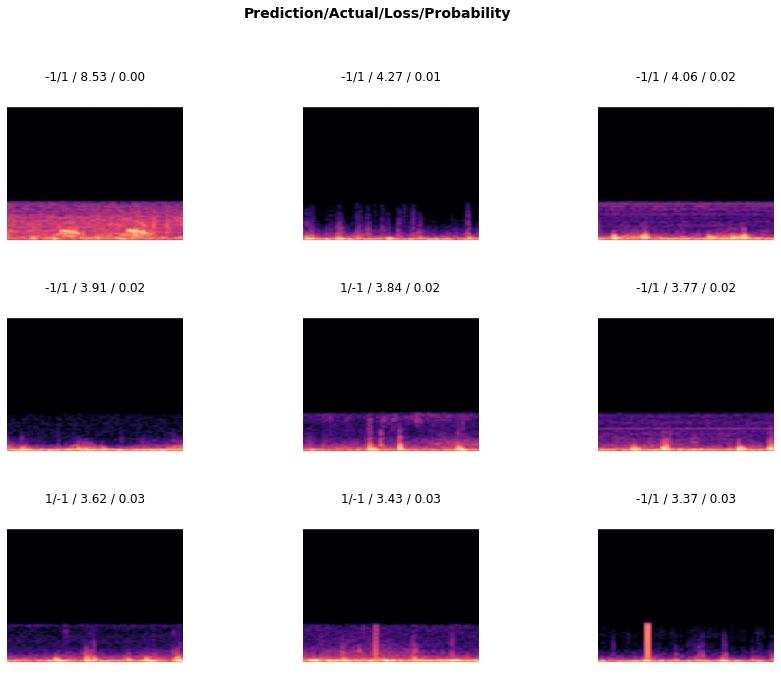

In [0]:
interp.plot_top_losses(9, figsize=(15,11))

In [0]:
doc(interp.plot_top_losses)

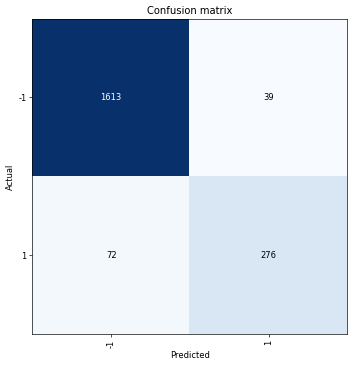

In [0]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

There's certainly some class imbalance here, and that's likely why there are more errors among the abnormal clips. May upsample.

## Fine Tuning

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.184024,0.133005,0.065500,02:04


In [0]:
learn.load('stage-1');

In [0]:
# Track the learning rate
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


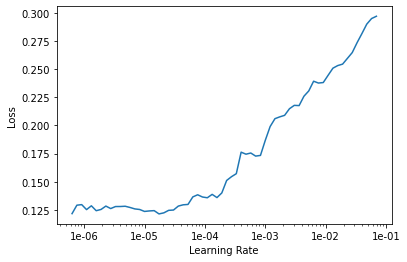

In [0]:
learn.recorder.plot()

In [0]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.133319,0.129333,0.050500,02:01
1,0.099085,0.125966,0.052000,02:03


## Resnet 50

In [0]:
data = ImageDataBunch.from_name_re(path_train, fnames, pat,
                                   size=299, bs=bs//2).normalize(imagenet_stats)

In [0]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


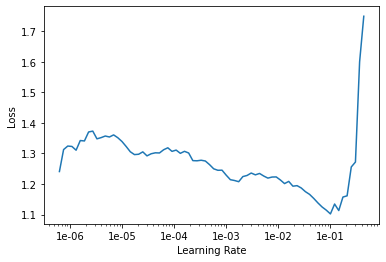

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,0.541894,1.336453,0.511000,02:47
1,0.246029,0.216645,0.078000,02:46
2,0.216807,0.578132,0.272500,02:46
3,0.178595,0.350991,0.110000,02:46
4,0.135397,0.979729,0.165500,02:48
5,0.103566,0.328952,0.093000,02:49
6,0.073813,0.179647,0.061000,02:47
7,0.051804,0.151416,0.052500,02:48


In [0]:
learn.save('stage-1-50')

In [0]:
learn.load('stage-1-50');

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

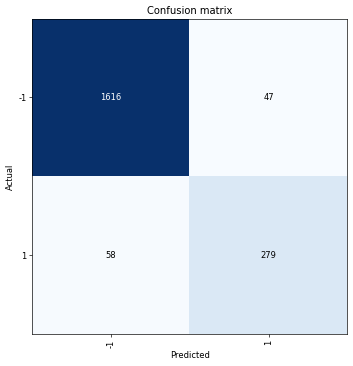

In [0]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

## Scoring on test

In [0]:
y_pred, y_test = learn.get_preds(data_test)

In [0]:
y_pred_num = []
for y in y_pred:
  if y[0] > y[1]:
    y_pred_num.append(0)
  else:
    y_pred_num.append(1)

In [0]:
y_pred_num = tensor(y_pred_num)

In [0]:
y_pred_num

tensor([0, 0, 0,  ..., 0, 1, 1])

In [0]:
score = to_float(auc_roc_score(y_pred_num, y_test))

In [0]:
false_positive_rate, true_positive_rate = roc_curve(y_pred_num, y_test)

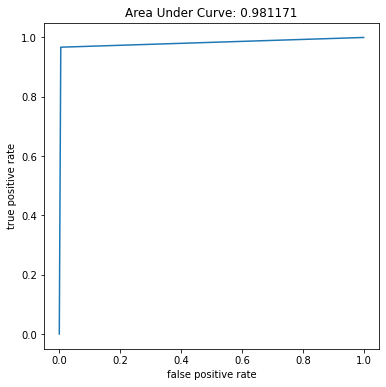

In [0]:
plt.figure(figsize=(6, 6))
plt.plot(false_positive_rate, true_positive_rate)
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Area Under Curve: %f' % score)
plt.show()